In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'APA Variation 6 CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Manulife Financial Corporation Stock Data

### No other stock price

In [5]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.829004,15.783375,-11.666669,832986.0,0.0
2000-01-24,17.424242,16.035816,-16.883143,3962574.0,2.0
2000-01-25,16.964287,16.178658,-27.922065,1711248.0,2.0
2000-01-26,17.153681,16.328661,-24.324314,3808959.0,2.0
2000-01-27,16.964287,16.426450,-34.399988,2355969.0,2.0


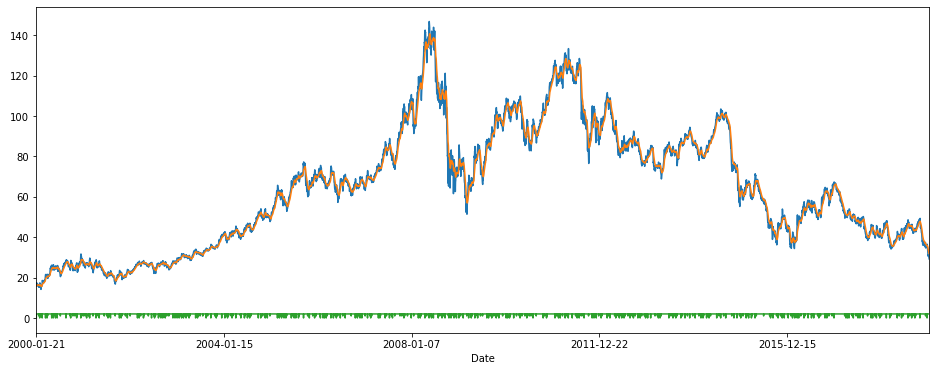

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [8]:
willr_data = np.array(willr_data)
willr_data.shape

(4745, 15, 1)

In [9]:
price_data = np.array(price_data)
price_data.shape

(4745, 15, 1)

In [10]:
ema_data = np.array(ema_data)
ema_data.shape

(4745, 15, 1)

In [11]:
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [13]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

In [14]:
from collections import Counter

Counter(y)

Counter({2.0: 4337, 0.0: 210, 1.0: 198})

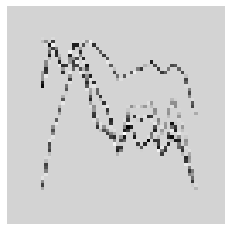

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.531746031746032, 1: 8.0084388185654, 2: 0.36464937560038424}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.4212 - accuracy: 0.6719 - mse: 5.5225 - weighted_accuracy: 0.4142 - weighted_mse: 6.4569WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 23ms/step - loss: 0.2517 - accuracy: 0.3733 - mse: 1.6487 - weighted_accuracy: 0.3177 - weighted_mse: 1.7532 - val_loss: 0.2043 - val_accuracy: 0.0421 - val_mse: 1.1587 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 1.1587
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2069 - accuracy: 0.2679 - mse: 1.1812 - weighted_accuracy: 0.3398 - weighted_mse: 1.1969 - val_loss: 0.2066 - val_accuracy: 0.0485 - val

Epoch 27/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1975 - accuracy: 0.2682 - mse: 1.1707 - weighted_accuracy: 0.4046 - weighted_mse: 1.1652 - val_loss: 0.1960 - val_accuracy: 0.1791 - val_mse: 0.8977 - val_weighted_accuracy: 0.1791 - val_weighted_mse: 0.8977
Epoch 28/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1974 - accuracy: 0.2597 - mse: 1.1743 - weighted_accuracy: 0.4014 - weighted_mse: 1.1724 - val_loss: 0.1978 - val_accuracy: 0.0717 - val_mse: 0.9467 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 0.9467
Epoch 29/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1967 - accuracy: 0.2698 - mse: 1.1744 - weighted_accuracy: 0.4120 - weighted_mse: 1.1715 - val_loss: 0.1952 - val_accuracy: 0.0706 - val_mse: 1.0265 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 1.0265
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1966 - accuracy: 0.2671 - mse: 1.2007 - weighted_accuracy: 0.4210 - we

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1783 - accuracy: 0.1762 - mse: 1.2549 - weighted_accuracy: 0.5160 - weighted_mse: 1.2057 - val_loss: 0.1972 - val_accuracy: 0.1138 - val_mse: 1.0336 - val_weighted_accuracy: 0.1138 - val_weighted_mse: 1.0336
Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1752 - accuracy: 0.1670 - mse: 1.2451 - weighted_accuracy: 0.5359 - weighted_mse: 1.1891 - val_loss: 0.1954 - val_accuracy: 0.1423 - val_mse: 1.0912 - val_weighted_accuracy: 0.1423 - val_weighted_mse: 1.0912
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1732 - accuracy: 0.1715 - mse: 1.3118 - weighted_accuracy: 0.5414 - weighted_mse: 1.2706 - val_loss: 0.1961 - val_accuracy: 0.1296 - val_mse: 1.0796 - val_weighted_accuracy: 0.1296 - val_weighted_mse: 1.0796
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1720 - accuracy: 0.1646 - mse: 1.2820 - weighted_accuracy: 0.5467 - weig

Epoch 85/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1534 - accuracy: 0.2194 - mse: 1.4416 - weighted_accuracy: 0.6254 - weighted_mse: 1.4217 - val_loss: 0.1936 - val_accuracy: 0.2413 - val_mse: 1.2823 - val_weighted_accuracy: 0.2413 - val_weighted_mse: 1.2823
Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1540 - accuracy: 0.2179 - mse: 1.4782 - weighted_accuracy: 0.6115 - weighted_mse: 1.4514 - val_loss: 0.1936 - val_accuracy: 0.2413 - val_mse: 1.2939 - val_weighted_accuracy: 0.2413 - val_weighted_mse: 1.2939
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1499 - accuracy: 0.2287 - mse: 1.4878 - weighted_accuracy: 0.6357 - weighted_mse: 1.4831 - val_loss: 0.1917 - val_accuracy: 0.2434 - val_mse: 1.2783 - val_weighted_accuracy: 0.2434 - val_weighted_mse: 1.2783
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1509 - accuracy: 0.2231 - mse: 1.4971 - weighted_accuracy: 0.6403 - weig

Epoch 114/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1370 - accuracy: 0.3288 - mse: 1.6936 - weighted_accuracy: 0.7007 - weighted_mse: 1.7910 - val_loss: 0.1823 - val_accuracy: 0.3709 - val_mse: 1.5143 - val_weighted_accuracy: 0.3709 - val_weighted_mse: 1.5143
Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1362 - accuracy: 0.3235 - mse: 1.7366 - weighted_accuracy: 0.6816 - weighted_mse: 1.8916 - val_loss: 0.1819 - val_accuracy: 0.3772 - val_mse: 1.5231 - val_weighted_accuracy: 0.3772 - val_weighted_mse: 1.5231
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1343 - accuracy: 0.3293 - mse: 1.7640 - weighted_accuracy: 0.6890 - weighted_mse: 1.9222 - val_loss: 0.1854 - val_accuracy: 0.3699 - val_mse: 1.5194 - val_weighted_accuracy: 0.3699 - val_weighted_mse: 1.5194
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1372 - accuracy: 0.3459 - mse: 1.6875 - weighted_accuracy: 0.6935 -

Epoch 143/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1234 - accuracy: 0.4895 - mse: 1.9666 - weighted_accuracy: 0.7572 - weighted_mse: 2.2977 - val_loss: 0.1675 - val_accuracy: 0.5100 - val_mse: 1.6389 - val_weighted_accuracy: 0.5100 - val_weighted_mse: 1.6389
Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1230 - accuracy: 0.4779 - mse: 1.9890 - weighted_accuracy: 0.7628 - weighted_mse: 2.4182 - val_loss: 0.1609 - val_accuracy: 0.5564 - val_mse: 1.6671 - val_weighted_accuracy: 0.5564 - val_weighted_mse: 1.6671
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1238 - accuracy: 0.4813 - mse: 2.0915 - weighted_accuracy: 0.7589 - weighted_mse: 2.4978 - val_loss: 0.1558 - val_accuracy: 0.5743 - val_mse: 1.7119 - val_weighted_accuracy: 0.5743 - val_weighted_mse: 1.7119
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1189 - accuracy: 0.4916 - mse: 2.0425 - weighted_accuracy: 0.7684 -

Epoch 172/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1091 - accuracy: 0.6091 - mse: 2.5329 - weighted_accuracy: 0.8114 - weighted_mse: 3.3706 - val_loss: 0.1407 - val_accuracy: 0.6818 - val_mse: 2.0800 - val_weighted_accuracy: 0.6818 - val_weighted_mse: 2.0800
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1076 - accuracy: 0.6051 - mse: 2.5829 - weighted_accuracy: 0.8213 - weighted_mse: 3.3444 - val_loss: 0.1393 - val_accuracy: 0.6702 - val_mse: 1.9758 - val_weighted_accuracy: 0.6702 - val_weighted_mse: 1.9758
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1103 - accuracy: 0.6101 - mse: 2.5867 - weighted_accuracy: 0.8159 - weighted_mse: 3.3300 - val_loss: 0.1389 - val_accuracy: 0.6986 - val_mse: 2.0676 - val_weighted_accuracy: 0.6986 - val_weighted_mse: 2.0676
Epoch 175/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1085 - accuracy: 0.6207 - mse: 2.6130 - weighted_accuracy: 0.8155 -

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11272601038217545
Test accuracy: 0.8303477168083191


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.8493843  -1.3842084   0.02038835]
 [-1.7793158  -1.3200465  -0.14731403]
 [-0.99732447 -1.78503    -0.27725828]
 ...
 [-2.3739443  -0.7060577  -0.23189047]
 [-1.4703647  -1.8138809   0.01245417]
 [-2.4636192  -0.5853081  -0.3160408 ]]


Counter({2: 840, 1: 44, 0: 65})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 867, 0: 42, 1: 40})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 949
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 33
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 34
actual holds but predicted buy: 37
actual holds but predicted sell: 57
actual predicted holds: 773
Percentage buys correct: 17.5%
Percentage sells correct: 19.047619047619047%
Percentage holds correct: 89.15801614763552%
actual buys: 40
actual sells: 42
actual holds: 867


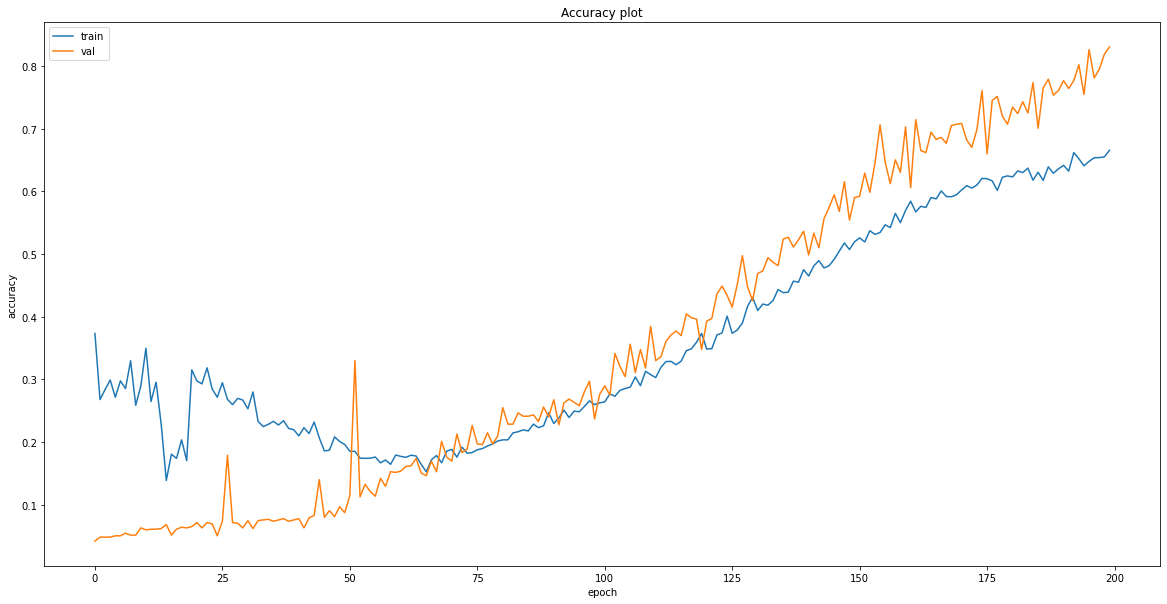

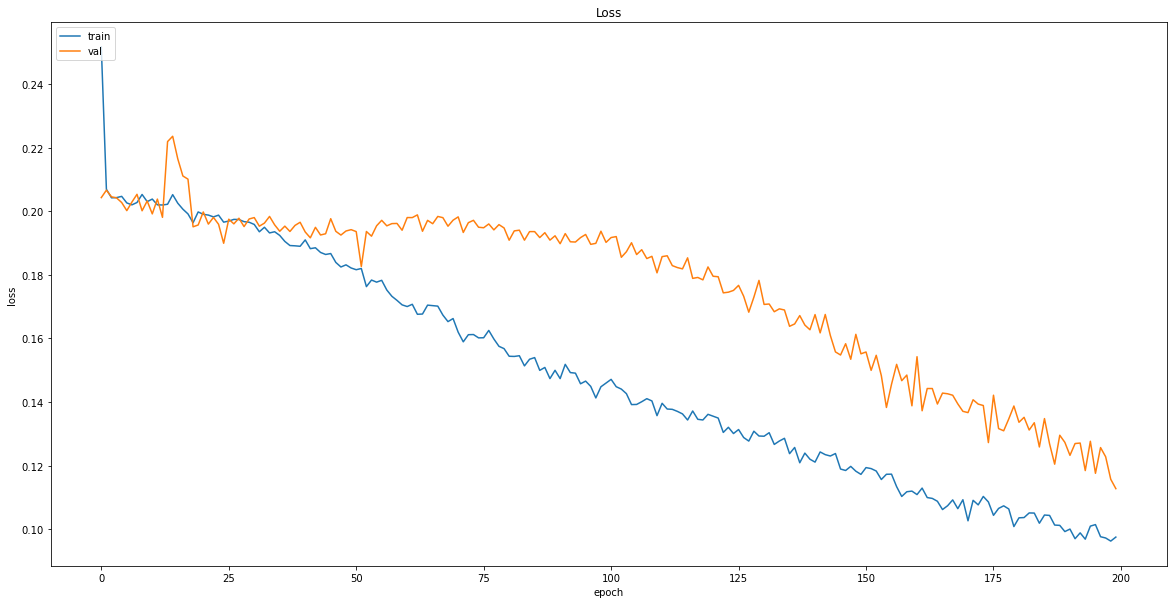

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('APA_no_support_image_cnn_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/APA_no_support_image_cnn_buy_hold_sell.model\assets


### Test Performance

### Non-Recession Test Data

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,32.090000,30.219349,-6.069339,51546400.0,2.0
2019-01-23,31.520000,30.419449,-14.306331,47385100.0,1.0
2019-01-24,30.969999,30.504149,-26.101688,43194000.0,2.0
2019-01-25,31.840000,30.709665,-13.293617,47637700.0,2.0
2019-01-28,32.060001,30.917409,-9.803859,52112900.0,2.0


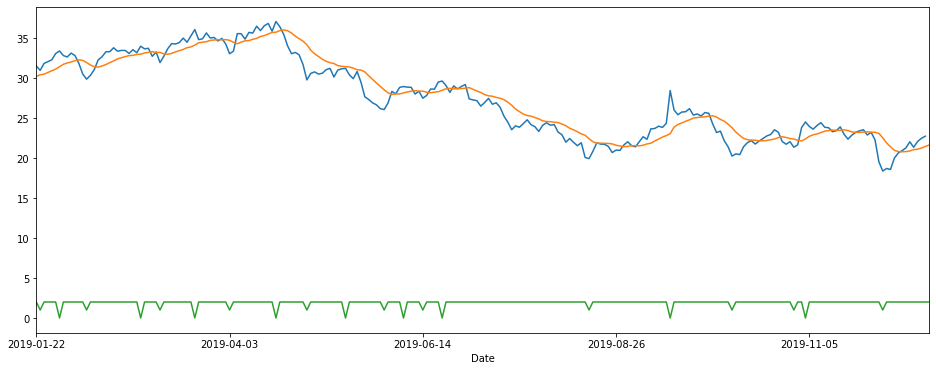

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [36]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [37]:
model = tf.keras.models.load_model("models/APA_no_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 14ms/step - loss: 0.1228 - accuracy: 0.7798 - mean_squared_error: 2.5624 - weighted_accuracy: 0.7798 - weighted_mean_squared_error: 2.5624
Test loss: 0.12279379367828369
Test accuracy: 0.7798165082931519


In [38]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 185, 1: 19, 0: 14})

In [39]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 8, 1: 9})

In [40]:
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test.csv")
df.set_index('Date', inplace=True)

In [41]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,30.350000,31.637367,-86.778818,44501400.0,2.0,2,2
2019-02-12,31.080000,31.439311,-75.240367,47729600.0,2.0,2,2
2019-02-13,32.279999,31.384032,-57.692301,52547300.0,2.0,1,2
2019-02-14,32.669998,31.521873,-28.846173,57269000.0,2.0,2,2
2019-02-15,33.299999,31.698508,-19.471188,61241600.0,2.0,2,2


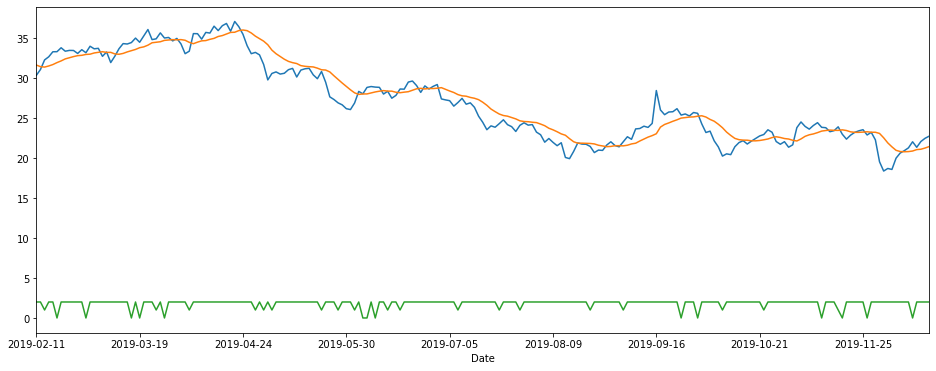

In [42]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

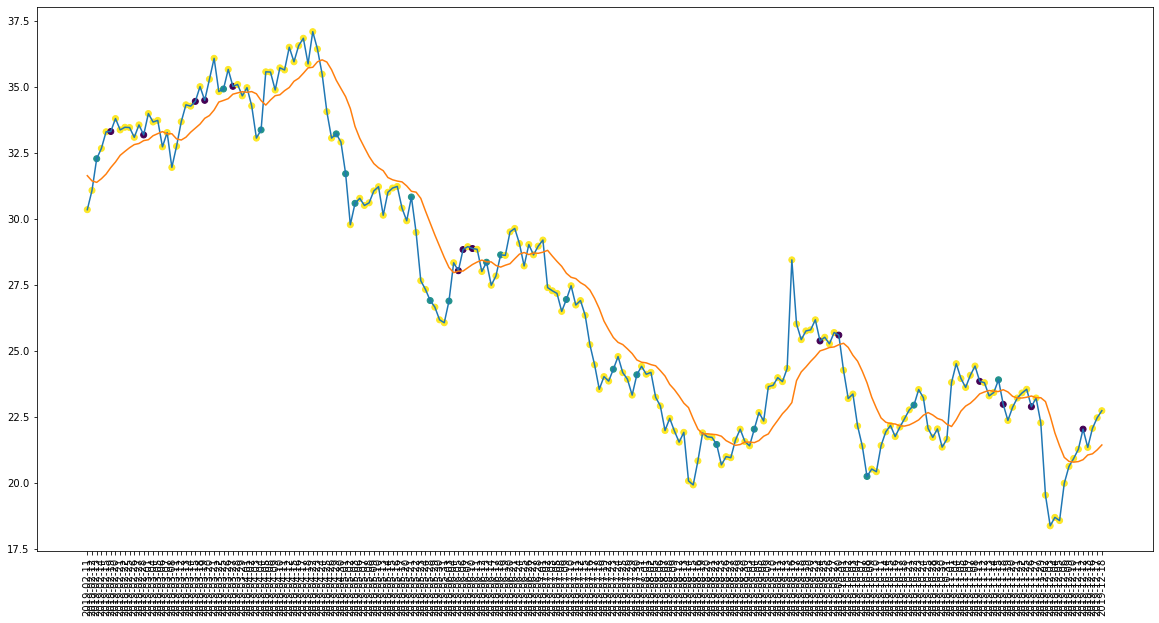

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

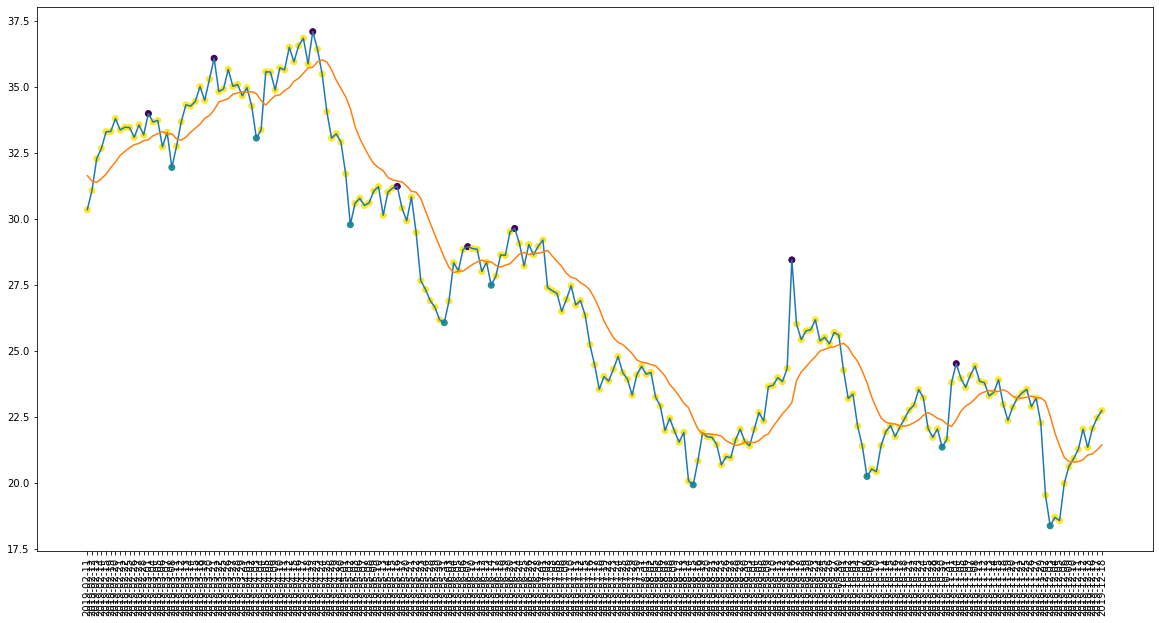

In [44]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [45]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 18
actual holds but predicted sell: 14
actual predicted holds: 169
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 0.0%
Percentage holds correct: 84.07960199004975%
actual buys: 9
actual sells: 8
actual holds: 201


In [46]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[30.35000038146973, 31.07999992370605, 32.279998779296875, 32.669998168945305, 33.299999237060554, 33.310001373291016, 33.36999893188477, 33.470001220703125, 33.799999237060554]
[33.09000015258789, 33.18000030517578, 33.36999893188477, 33.459999084472656, 33.470001220703125, 33.560001373291016, 33.669998168945305, 33.799999237060554, 33.990001678466804]
Percentage buys correct: 47.36842105263158%
Percentage sells correct: 35.714285714285715%
Percentage holds correct: 80.43478260869566%


In [47]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $32.279998779296875
Shares owned at the moment: 308
Cash capital at the moment: $30.41921701049796


Price increase from previously bought: 6.429753326133647%
Share price: $34.450000762939446
Shares owned at the moment: 0
Cash capital at the moment: $10611.840301349637


Share price: $34.919998168945305
Shares owned at the moment: 303
Cash capital at the moment: $1.983767684934719


Stop Loss Activated!

Share price: $33.060001373291016
Shares owned at the moment: 0
Cash capital at the moment: $9991.616937647817


Share price: $33.36999893188477
Shares owned at the moment: 298
Cash capital at the moment: $20.01054182147527


Stop Loss Activated!

Share price: $31.709999084472656
Shares owned at the moment: 0
Cash capital at the moment: $9443.6039247446


Share price: $31.709999084472656
Shares owned at the moment: 296
Cash capital at the moment: $31.632256485932885


Stop Loss Activated!

Share price: $29.78000068664551
Shares owned at the moment: 0
Cash capital at the mom

In [48]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7456.032619667051
profit gained: -25.439673803329487%


In [49]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.779817,11.11111111111111%,0.0%,84.07960199004975%,47.36842105263158%,35.714285714285715%,80.43478260869566%,-16.38254588816177%,-25.439673803329487%


### Recession test data

In [50]:
logger = []

In [51]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    31.740000  30.898076 -22.580653  22551800.0     2.0
2020-01-23    30.870001  30.893757 -33.564805  17841100.0     2.0
2020-01-24    30.270000  30.797795 -40.697673  13024900.0     2.0
2020-01-27    29.980000  30.671980 -44.069776   9552800.0     2.0
2020-01-28    28.850000  30.391675 -95.533989   5310000.0     2.0


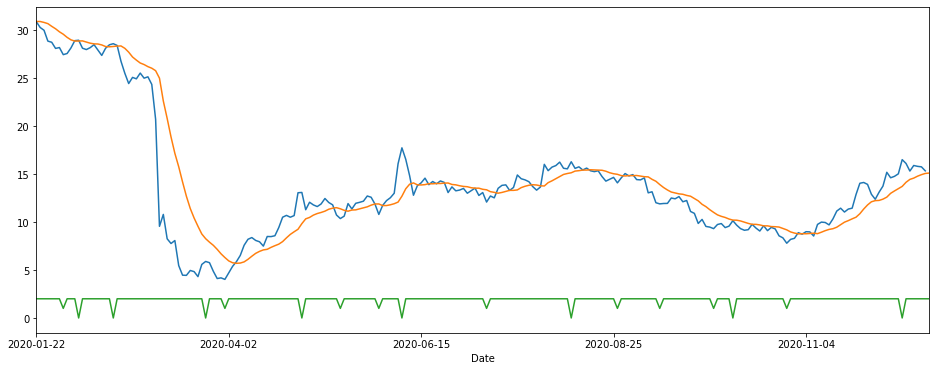

In [52]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [53]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [54]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [56]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [57]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [58]:
model = tf.keras.models.load_model("models/APA_no_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 24ms/step - loss: 0.1121 - accuracy: 0.8082 - mean_squared_error: 2.5044 - weighted_accuracy: 0.8082 - weighted_mean_squared_error: 2.5044
Test loss: 0.11211085319519043
Test accuracy: 0.8082191944122314


In [59]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 190, 0: 15, 1: 14})

In [60]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [61]:
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test2.csv")
df.set_index('Date', inplace=True)

In [62]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,28.170000,28.634380,-77.333366,7103100.0,2.0,2,2
2020-02-12,28.480000,28.562937,-66.847830,9173500.0,2.0,2,2
2020-02-13,27.920000,28.550178,-51.118237,12393300.0,2.0,2,2
2020-02-14,27.360001,28.453227,-61.811036,8895100.0,2.0,2,2
2020-02-18,28.110001,28.285039,-83.534141,4602800.0,2.0,2,2


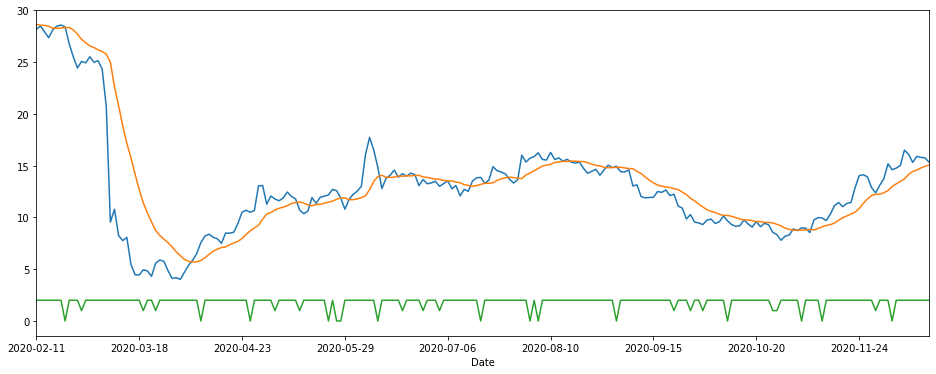

In [63]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

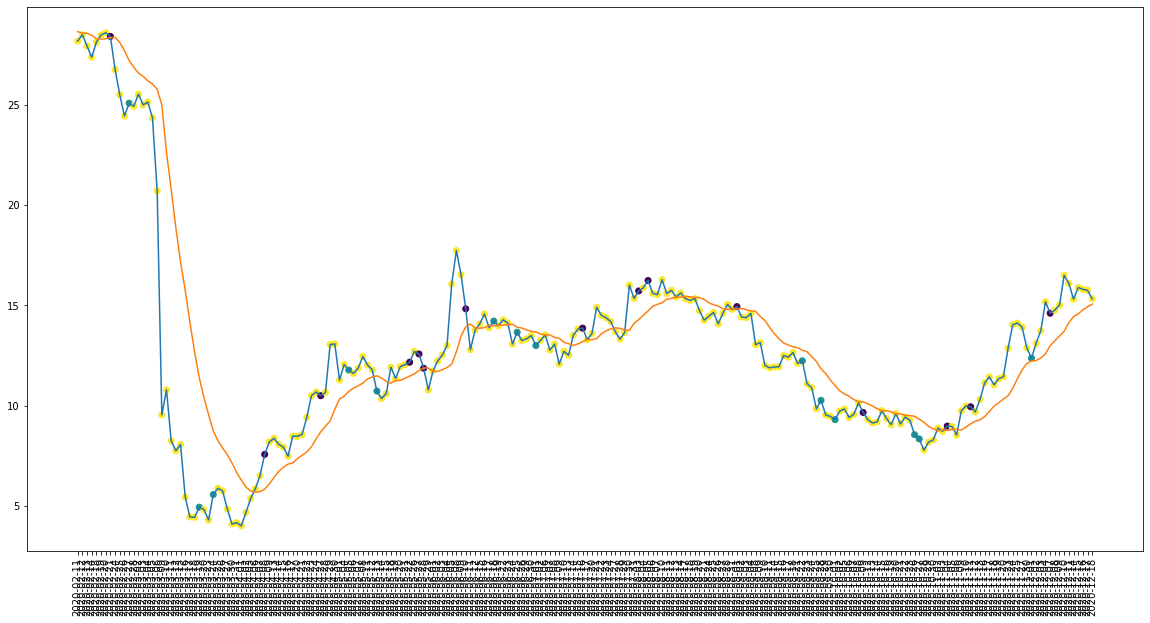

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

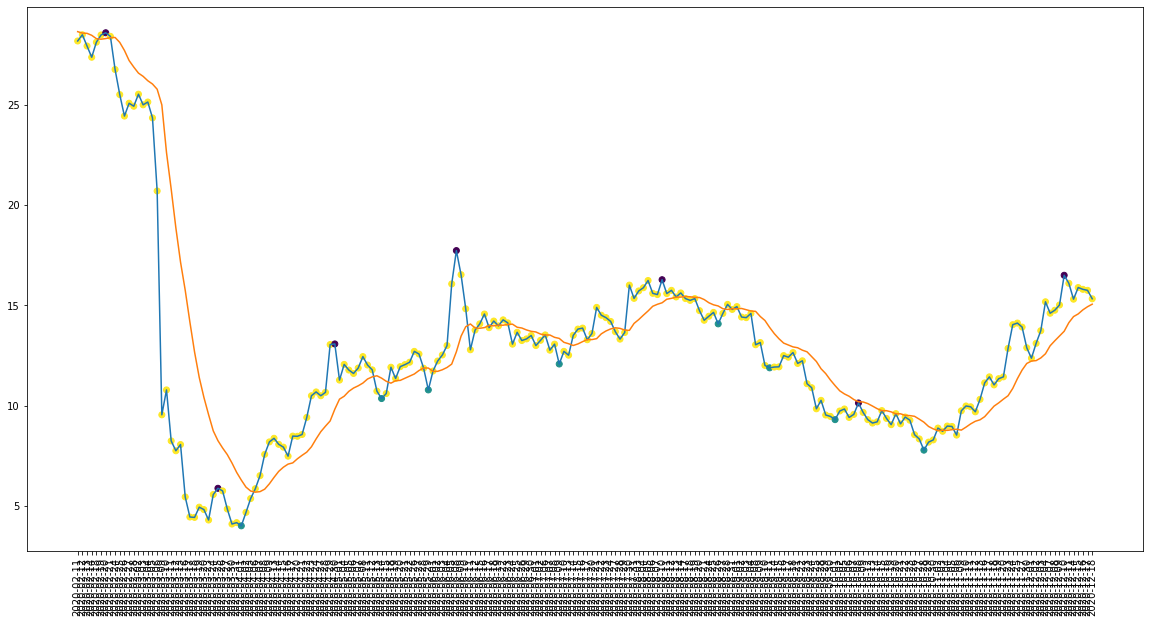

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 13
actual holds but predicted sell: 15
actual predicted holds: 176
Percentage buys correct: 12.5%
Percentage sells correct: 0.0%
Percentage holds correct: 86.27450980392157%
actual buys: 8
actual sells: 7
actual holds: 204


In [67]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[26.75, 27.36000061035156, 27.920000076293945, 28.11000061035156, 28.170000076293945, 28.399999618530273, 28.46999931335449, 28.479999542236328, 28.57999992370605]
[24.43000030517578, 24.920000076293945, 24.989999771118164, 25.06999969482422, 25.5, 25.520000457763672, 26.75, 28.399999618530273, 28.57999992370605]
Percentage buys correct: 50.0%
Percentage sells correct: 66.66666666666667%
Percentage holds correct: 83.5978835978836%


In [68]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $25.06999969482422
Shares owned at the moment: 397
Cash capital at the moment: $19.83994898796118


Stop Loss Activated!

Share price: $24.34000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9656.246814398766


Share price: $4.949999809265137
Shares owned at the moment: 1945
Cash capital at the moment: $2.020873898267382


Stop Loss Activated!

Share price: $4.309999942779541
Shares owned at the moment: 0
Cash capital at the moment: $8361.917650410533


Share price: $5.579999923706055
Shares owned at the moment: 1494
Cash capital at the moment: $2.472334707139453


Stop Loss Activated!

Share price: $4.860000133514403
Shares owned at the moment: 0
Cash capital at the moment: $7243.345223629114


Share price: $11.779999732971193
Shares owned at the moment: 613
Cash capital at the moment: $2.3472527679168707


Stop Loss Activated!

Share price: $10.729999542236328
Shares owned at the moment: 0
Cash capital at the moment: $6561.748875430461


Share price

In [69]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5412.292695983887
profit gained: -45.87707304016113%


In [70]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.779817,11.11111111111111%,0.0%,84.07960199004975%,47.36842105263158%,35.714285714285715%,80.43478260869566%,-16.38254588816177%,-25.439673803329487%
1,0.808219,12.5%,0.0%,86.27450980392157%,50.0%,66.66666666666667%,83.5978835978836%,-58.396856798566645%,-45.87707304016113%


### with XOM stock price

In [71]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.829004,15.783375,-11.666669,832986.0,0.0
2000-01-24,17.424242,16.035816,-16.883143,3962574.0,2.0
2000-01-25,16.964287,16.178658,-27.922065,1711248.0,2.0
2000-01-26,17.153681,16.328661,-24.324314,3808959.0,2.0
2000-01-27,16.964287,16.426450,-34.399988,2355969.0,2.0


In [72]:
df2 = pd.read_csv("data/variation 6/initial_indicators/XOM_data.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,41.84375,41.600345,-26.282051,1187400.0,2.0
2000-01-24,42.50000,41.738754,-12.820513,15531000.0,2.0
2000-01-25,42.12500,41.798176,-21.019108,3071600.0,2.0
2000-01-26,42.03125,41.834034,-26.470588,-8850000.0,2.0
2000-01-27,41.75000,41.821105,-45.918367,-18148000.0,2.0


In [73]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2000-01-21,16.829004,15.783375,-11.666669,832986.0,0.0,41.84375
2000-01-24,17.424242,16.035816,-16.883143,3962574.0,2.0,42.50000
2000-01-25,16.964287,16.178658,-27.922065,1711248.0,2.0,42.12500
2000-01-26,17.153681,16.328661,-24.324314,3808959.0,2.0,42.03125
2000-01-27,16.964287,16.426450,-34.399988,2355969.0,2.0,41.75000


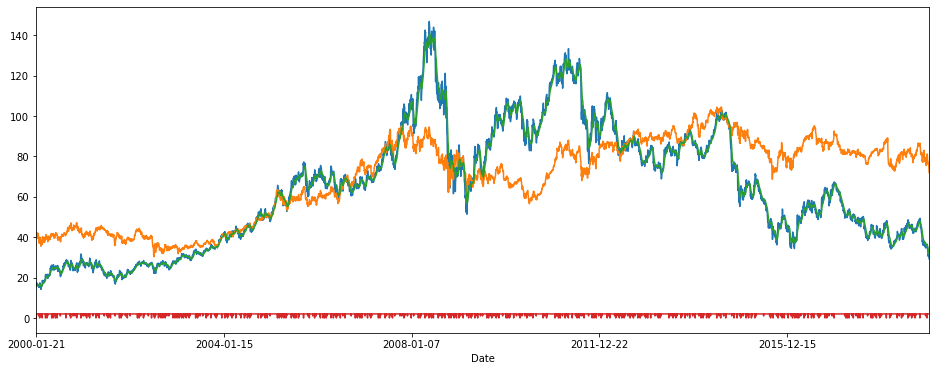

In [74]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['support'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [75]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    n = support_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)
    ax.plot(n)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [77]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

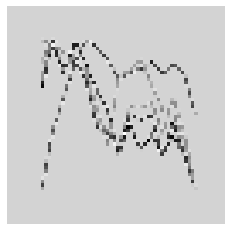

In [78]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [79]:
X = X/255

In [80]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [81]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [82]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [84]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.531746031746032, 1: 8.0084388185654, 2: 0.36464937560038424}
Epoch 1/200
30/30 [==============================] - 2s 70ms/step - loss: 0.2510 - accuracy: 0.3701 - mse: 1.6153 - weighted_accuracy: 0.2958 - weighted_mse: 1.7159 - val_loss: 0.2056 - val_accuracy: 0.0432 - val_mse: 1.1462 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 1.1462
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2058 - accuracy: 0.3493 - mse: 1.1908 - weighted_accuracy: 0.3491 - weighted_mse: 1.2211 - val_loss: 0.2017 - val_accuracy: 0.1454 - val_mse: 0.8624 - val_weighted_accuracy: 0.1454 - val_weighted_mse: 0.8624
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2025 - accuracy: 0.3696 - mse: 1.1659 - weighted_accuracy: 0.3546 - weighted_mse: 1.1901 - val_loss: 0.1968 - val_accuracy: 0.5153 - val_mse: 0.8700 - val_weighted_accuracy: 0.5153 - val_weighted_mse: 0.8700
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2037 - 

30/30 [==============================] - 0s 10ms/step - loss: 0.1980 - accuracy: 0.3348 - mse: 1.1681 - weighted_accuracy: 0.3746 - weighted_mse: 1.1635 - val_loss: 0.1977 - val_accuracy: 0.0685 - val_mse: 0.9867 - val_weighted_accuracy: 0.0685 - val_weighted_mse: 0.9867
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1977 - accuracy: 0.3483 - mse: 1.1683 - weighted_accuracy: 0.3661 - weighted_mse: 1.1772 - val_loss: 0.1946 - val_accuracy: 0.1465 - val_mse: 0.9704 - val_weighted_accuracy: 0.1465 - val_weighted_mse: 0.9704
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1967 - accuracy: 0.3219 - mse: 1.1794 - weighted_accuracy: 0.3667 - weighted_mse: 1.1763 - val_loss: 0.1955 - val_accuracy: 0.1612 - val_mse: 0.9452 - val_weighted_accuracy: 0.1612 - val_weighted_mse: 0.9452
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1953 - accuracy: 0.3056 - mse: 1.1709 - weighted_accuracy: 0.4095 - weighted_mse: 1.

Epoch 57/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1779 - accuracy: 0.2318 - mse: 1.2687 - weighted_accuracy: 0.5156 - weighted_mse: 1.2158 - val_loss: 0.1907 - val_accuracy: 0.2055 - val_mse: 1.0538 - val_weighted_accuracy: 0.2055 - val_weighted_mse: 1.0538
Epoch 58/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1774 - accuracy: 0.2505 - mse: 1.3001 - weighted_accuracy: 0.5317 - weighted_mse: 1.2667 - val_loss: 0.1860 - val_accuracy: 0.2782 - val_mse: 1.0590 - val_weighted_accuracy: 0.2782 - val_weighted_mse: 1.0590
Epoch 59/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1789 - accuracy: 0.2397 - mse: 1.2476 - weighted_accuracy: 0.4850 - weighted_mse: 1.2210 - val_loss: 0.1958 - val_accuracy: 0.1739 - val_mse: 1.0102 - val_weighted_accuracy: 0.1739 - val_weighted_mse: 1.0102
Epoch 60/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1745 - accuracy: 0.2208 - mse: 1.2966 - weighted_accuracy: 0.5350 - 

Epoch 86/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1558 - accuracy: 0.2358 - mse: 1.4132 - weighted_accuracy: 0.5952 - weighted_mse: 1.3842 - val_loss: 0.1985 - val_accuracy: 0.1749 - val_mse: 1.2542 - val_weighted_accuracy: 0.1749 - val_weighted_mse: 1.2542
Epoch 87/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1517 - accuracy: 0.2534 - mse: 1.4453 - weighted_accuracy: 0.6164 - weighted_mse: 1.4272 - val_loss: 0.1885 - val_accuracy: 0.2803 - val_mse: 1.2716 - val_weighted_accuracy: 0.2803 - val_weighted_mse: 1.2716
Epoch 88/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1526 - accuracy: 0.2555 - mse: 1.4143 - weighted_accuracy: 0.6258 - weighted_mse: 1.3930 - val_loss: 0.1867 - val_accuracy: 0.2708 - val_mse: 1.1906 - val_weighted_accuracy: 0.2708 - val_weighted_mse: 1.1906
Epoch 89/200
30/30 [==============================] - 0s 17ms/step - loss: 0.1495 - accuracy: 0.2445 - mse: 1.4505 - weighted_accuracy: 0.6254 - 

Epoch 115/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1321 - accuracy: 0.4220 - mse: 1.7201 - weighted_accuracy: 0.6974 - weighted_mse: 1.8444 - val_loss: 0.1787 - val_accuracy: 0.4110 - val_mse: 1.4474 - val_weighted_accuracy: 0.4110 - val_weighted_mse: 1.4474
Epoch 116/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1301 - accuracy: 0.4283 - mse: 1.6706 - weighted_accuracy: 0.7207 - weighted_mse: 1.7971 - val_loss: 0.1788 - val_accuracy: 0.3941 - val_mse: 1.4443 - val_weighted_accuracy: 0.3941 - val_weighted_mse: 1.4443
Epoch 117/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1296 - accuracy: 0.4115 - mse: 1.6845 - weighted_accuracy: 0.7014 - weighted_mse: 1.8227 - val_loss: 0.1730 - val_accuracy: 0.4499 - val_mse: 1.4863 - val_weighted_accuracy: 0.4499 - val_weighted_mse: 1.4863
Epoch 118/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1292 - accuracy: 0.4252 - mse: 1.7236 - weighted_accuracy: 0.714

Epoch 144/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1104 - accuracy: 0.5680 - mse: 2.0202 - weighted_accuracy: 0.7895 - weighted_mse: 2.4317 - val_loss: 0.1638 - val_accuracy: 0.5522 - val_mse: 1.7377 - val_weighted_accuracy: 0.5522 - val_weighted_mse: 1.7377
Epoch 145/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1158 - accuracy: 0.5530 - mse: 2.0637 - weighted_accuracy: 0.7518 - weighted_mse: 2.4566 - val_loss: 0.1403 - val_accuracy: 0.6913 - val_mse: 1.5913 - val_weighted_accuracy: 0.6913 - val_weighted_mse: 1.5913
Epoch 146/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1108 - accuracy: 0.5693 - mse: 1.9654 - weighted_accuracy: 0.7538 - weighted_mse: 2.3775 - val_loss: 0.1603 - val_accuracy: 0.5543 - val_mse: 1.5660 - val_weighted_accuracy: 0.5543 - val_weighted_mse: 1.5660
Epoch 147/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1081 - accuracy: 0.5796 - mse: 2.0706 - weighted_accuracy: 0.780

Epoch 173/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0987 - accuracy: 0.6515 - mse: 2.4355 - weighted_accuracy: 0.7927 - weighted_mse: 3.1420 - val_loss: 0.1316 - val_accuracy: 0.7376 - val_mse: 1.6908 - val_weighted_accuracy: 0.7376 - val_weighted_mse: 1.6908
Epoch 174/200
30/30 [==============================] - 1s 18ms/step - loss: 0.1010 - accuracy: 0.6641 - mse: 2.3715 - weighted_accuracy: 0.7904 - weighted_mse: 3.0192 - val_loss: 0.1267 - val_accuracy: 0.7376 - val_mse: 1.8669 - val_weighted_accuracy: 0.7376 - val_weighted_mse: 1.8669
Epoch 175/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1005 - accuracy: 0.6486 - mse: 2.4372 - weighted_accuracy: 0.7791 - weighted_mse: 3.1207 - val_loss: 0.1190 - val_accuracy: 0.7829 - val_mse: 1.8494 - val_weighted_accuracy: 0.7829 - val_weighted_mse: 1.8494
Epoch 176/200
30/30 [==============================] - 1s 17ms/step - loss: 0.0939 - accuracy: 0.6525 - mse: 2.4699 - weighted_accuracy: 0.807

In [85]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10915087163448334
Test accuracy: 0.8103266358375549


In [86]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.2410487  -1.8230903   0.1765399 ]
 [-1.3408103  -1.1967149   0.05763195]
 [-0.7089287  -1.3906493  -0.17509714]
 ...
 [-2.0316505  -0.80134517 -0.1523183 ]
 [-1.0643791  -2.381927    0.11216091]
 [-2.0753179  -0.5160462  -0.35136637]]


Counter({2: 831, 0: 61, 1: 57})

In [87]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 867, 0: 42, 1: 40})

In [88]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 34
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 38
actual holds but predicted buy: 51
actual holds but predicted sell: 57
actual predicted holds: 759
Percentage buys correct: 15.0%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 87.5432525951557%
actual buys: 40
actual sells: 42
actual holds: 867


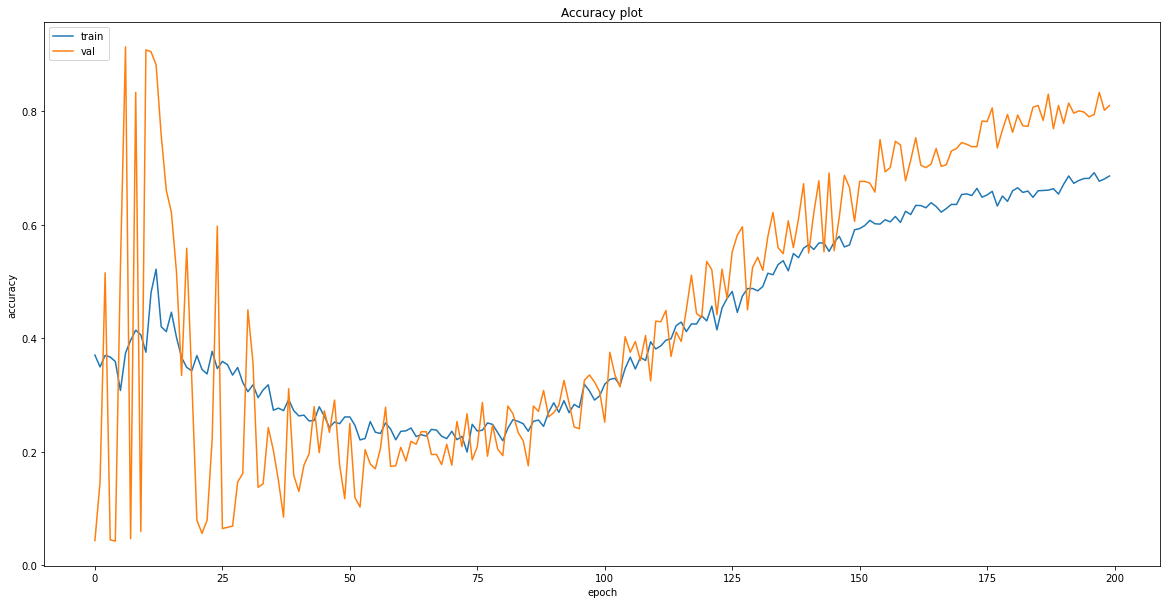

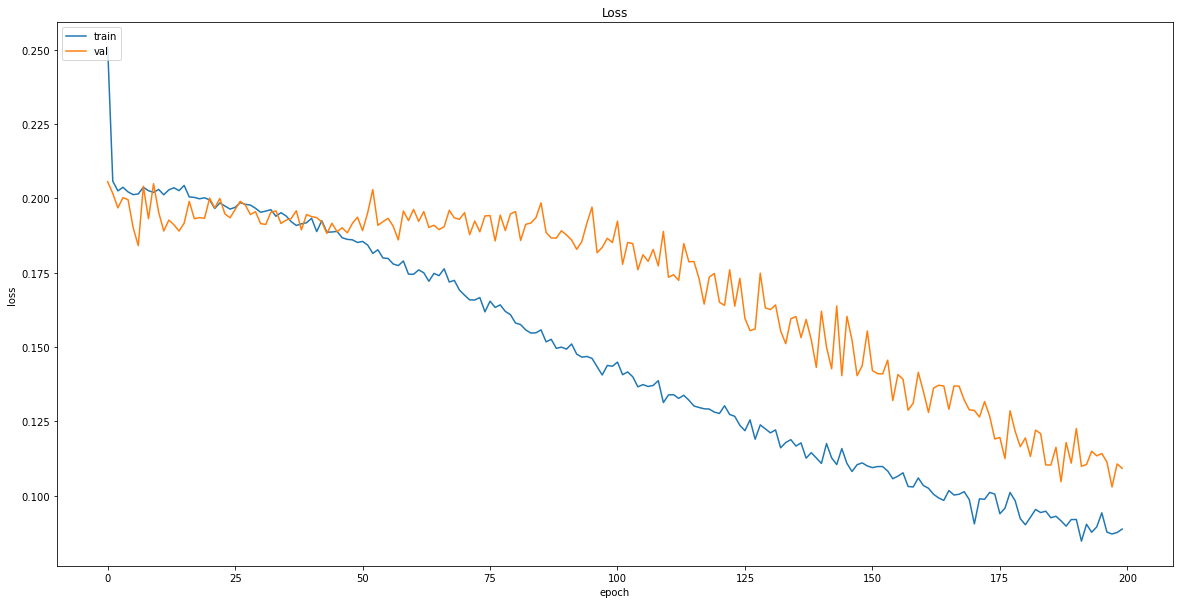

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
# Save model
model.save("models/{}".format('APA_support_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/APA_support_image_cnn_buy_hold_sell.model\assets


### Test Performance

### non-recession

In [91]:
logger = []

In [92]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    32.090000  30.219349  -6.069339  51546400.0     2.0
2019-01-23    31.520000  30.419449 -14.306331  47385100.0     1.0
2019-01-24    30.969999  30.504149 -26.101688  43194000.0     2.0
2019-01-25    31.840000  30.709665 -13.293617  47637700.0     2.0
2019-01-28    32.060001  30.917409  -9.803859  52112900.0     2.0


In [93]:
df2 = pd.read_csv("data/variation 6/initial_indicators/XOM_data_test.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,72.989998,71.473540,-4.975176,60118400.0,2.0
2019-01-23,71.889999,71.537611,-23.217277,45082800.0,2.0
2019-01-24,71.300003,71.501056,-40.365066,31895600.0,2.0
2019-01-25,71.400002,71.485509,-48.091584,43168100.0,2.0
2019-01-28,71.720001,71.521585,-59.245237,52164300.0,1.0


In [94]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2019-01-22,32.090000,30.219349,-6.069339,51546400.0,2.0,72.989998
2019-01-23,31.520000,30.419449,-14.306331,47385100.0,1.0,71.889999
2019-01-24,30.969999,30.504149,-26.101688,43194000.0,2.0,71.300003
2019-01-25,31.840000,30.709665,-13.293617,47637700.0,2.0,71.400002
2019-01-28,32.060001,30.917409,-9.803859,52112900.0,2.0,71.720001


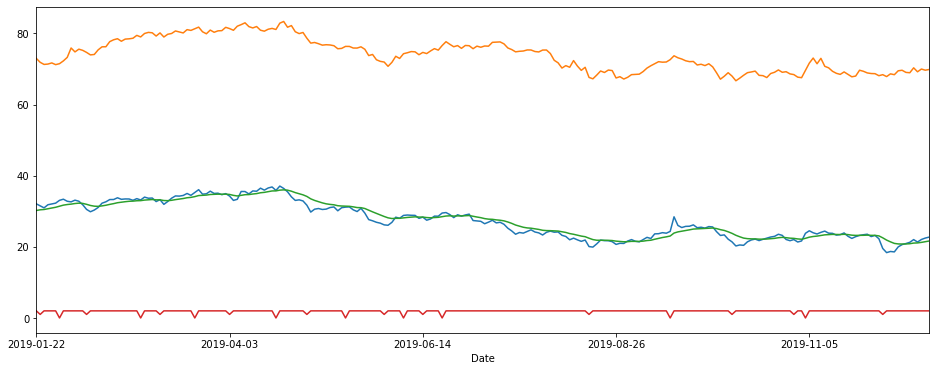

In [95]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['support'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [96]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [98]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [99]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [100]:
model = tf.keras.models.load_model("models/APA_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 4ms/step - loss: 0.1173 - accuracy: 0.7844 - mean_squared_error: 2.1087 - weighted_accuracy: 0.7844 - weighted_mean_squared_error: 2.1087
Test loss: 0.11733788251876831
Test accuracy: 0.7844036817550659


In [101]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 15, 2: 186, 0: 17})

In [102]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 8, 1: 9})

In [103]:
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test.csv")
df.set_index('Date', inplace=True)

In [104]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,30.350000,31.637367,-86.778818,44501400.0,2.0,1,2
2019-02-12,31.080000,31.439311,-75.240367,47729600.0,2.0,2,2
2019-02-13,32.279999,31.384032,-57.692301,52547300.0,2.0,2,2
2019-02-14,32.669998,31.521873,-28.846173,57269000.0,2.0,2,2
2019-02-15,33.299999,31.698508,-19.471188,61241600.0,2.0,2,2


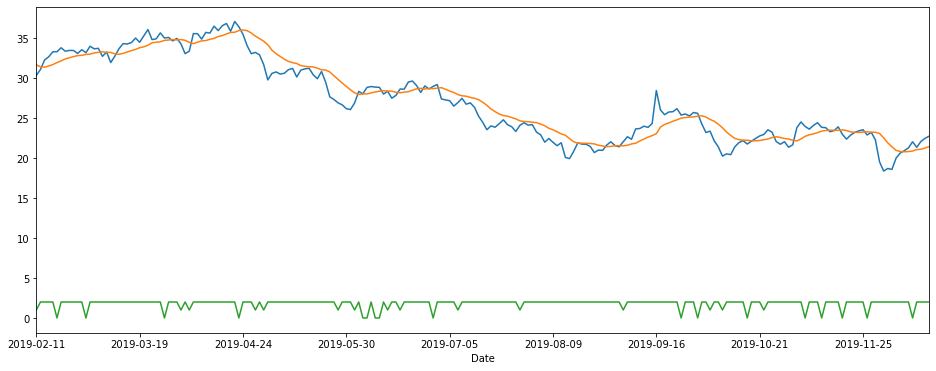

In [105]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

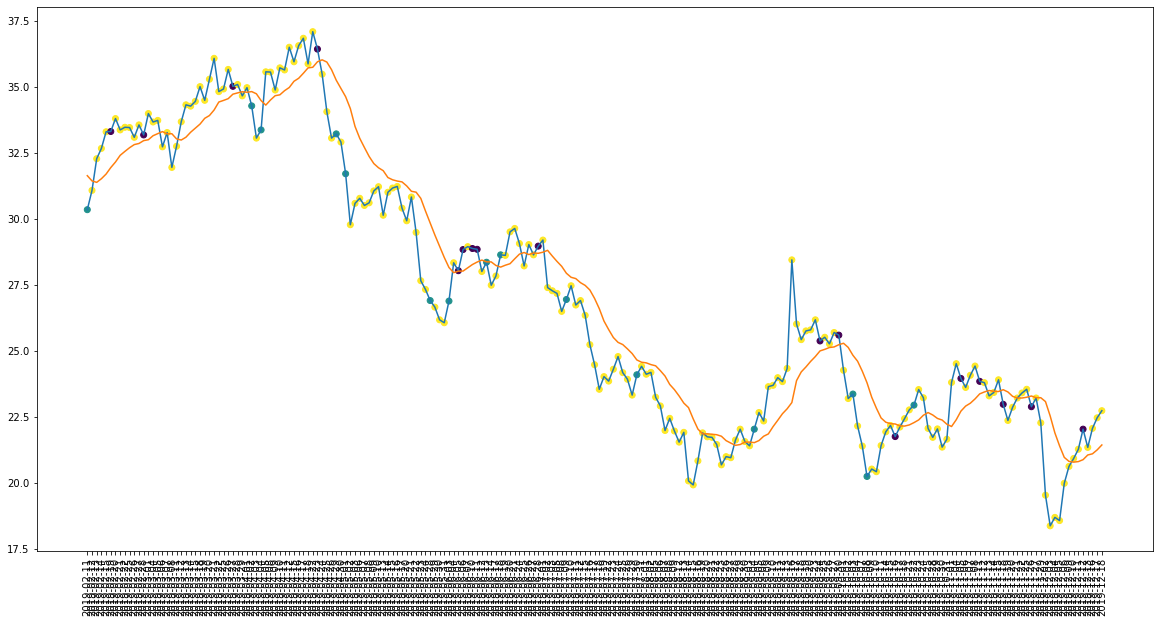

In [106]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

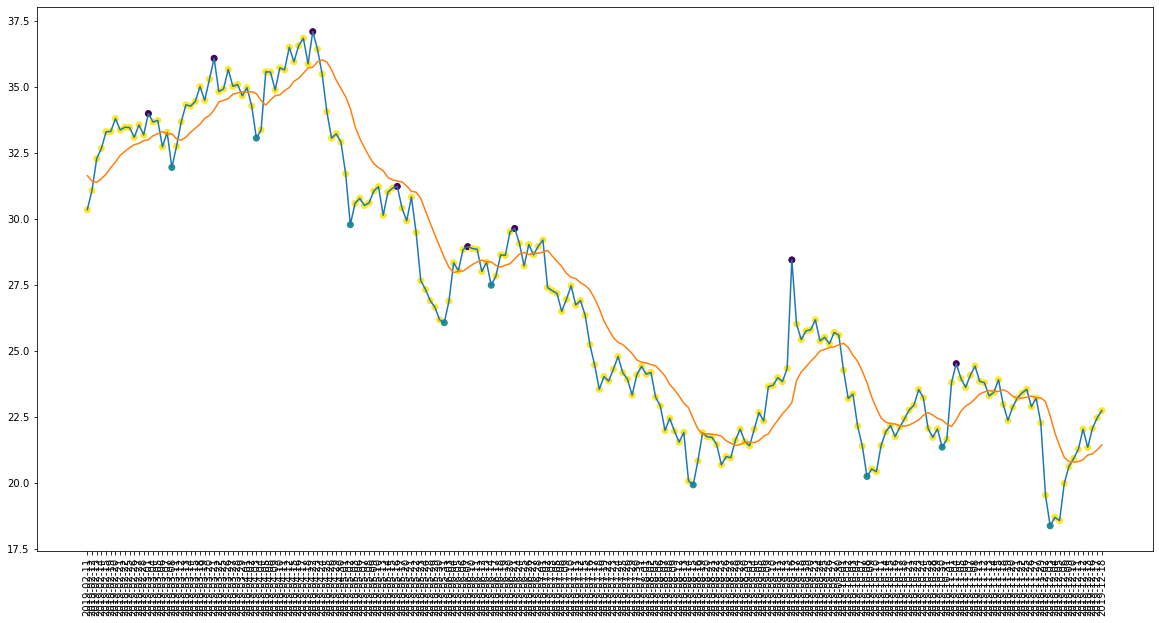

In [107]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [108]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 14
actual holds but predicted sell: 17
actual predicted holds: 170
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 0.0%
Percentage holds correct: 84.57711442786069%
actual buys: 9
actual sells: 8
actual holds: 201
[30.35000038146973, 31.07999992370605, 32.279998779296875, 32.669998168945305, 33.299999237060554, 33.310001373291016, 33.36999893188477, 33.470001220703125, 33.799999237060554]
[33.09000015258789, 33.18000030517578, 33.36999893188477, 33.459999084472656, 33.470001220703125, 33.560001373291016, 33.669998168945305, 33.799999237060554, 33.990001678466804]
Percentage buys correct: 53.333333333333336%
Percentage sells correct: 52.94117647058823%
Percentage holds correct: 80.0%


In [109]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $30.35000038146973
Shares owned at the moment: 328
Cash capital at the moment: $17.82417453384187


Price increase from previously bought: 9.451893469620742%
Share price: $33.310001373291016
Shares owned at the moment: 0
Cash capital at the moment: $10913.459003734586


Share price: $34.279998779296875
Shares owned at the moment: 317
Cash capital at the moment: $16.815801761624243


Stop Loss Activated!

Share price: $33.060001373291016
Shares owned at the moment: 0
Cash capital at the moment: $10468.01618089771


Share price: $33.36999893188477
Shares owned at the moment: 312
Cash capital at the moment: $27.945055066104032


Price increase from previously bought: 8.87052356465119%
Share price: $36.43000030517578
Shares owned at the moment: 0
Cash capital at the moment: $11362.848210019107


Share price: $33.220001220703125
Shares owned at the moment: 341
Cash capital at the moment: $3.675737614626996


Stop Loss Activated!

Share price: $31.709999084472656
Shares owned at

In [110]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7456.032619667051
profit gained: -25.439673803329487%


In [111]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.779817,11.11111111111111%,0.0%,84.07960199004975%,47.36842105263158%,35.714285714285715%,80.43478260869566%,-16.38254588816177%,-25.439673803329487%
1,0.808219,12.5%,0.0%,86.27450980392157%,50.0%,66.66666666666667%,83.5978835978836%,-58.396856798566645%,-45.87707304016113%
2,0.784404,11.11111111111111%,0.0%,84.57711442786069%,53.333333333333336%,52.94117647058823%,80.0%,-6.290706476936411%,-25.439673803329487%


### Recession

In [112]:
logger = []

In [113]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    31.740000  30.898076 -22.580653  22551800.0     2.0
2020-01-23    30.870001  30.893757 -33.564805  17841100.0     2.0
2020-01-24    30.270000  30.797795 -40.697673  13024900.0     2.0
2020-01-27    29.980000  30.671980 -44.069776   9552800.0     2.0
2020-01-28    28.850000  30.391675 -95.533989   5310000.0     2.0


In [114]:
df2 = pd.read_csv("data/variation 6/initial_indicators/XOM_data_test2.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-22,67.580002,69.273773,-98.186537,-68570400.0,2.0
2020-01-23,67.190002,68.953193,-95.652121,-85603500.0,2.0
2020-01-24,66.769997,68.617316,-86.466285,-105209400.0,2.0
2020-01-27,66.320000,68.263883,-94.736865,-123448000.0,2.0
2020-01-28,64.739998,67.721747,-99.312699,-144679000.0,2.0


In [115]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2020-01-22,31.740000,30.898076,-22.580653,22551800.0,2.0,67.580002
2020-01-23,30.870001,30.893757,-33.564805,17841100.0,2.0,67.190002
2020-01-24,30.270000,30.797795,-40.697673,13024900.0,2.0,66.769997
2020-01-27,29.980000,30.671980,-44.069776,9552800.0,2.0,66.320000
2020-01-28,28.850000,30.391675,-95.533989,5310000.0,2.0,64.739998


In [116]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [118]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [119]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [120]:
model = tf.keras.models.load_model("models/APA_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 6ms/step - loss: 0.1053 - accuracy: 0.8265 - mean_squared_error: 2.0635 - weighted_accuracy: 0.8265 - weighted_mean_squared_error: 2.0635
Test loss: 0.10528382658958435
Test accuracy: 0.8264840245246887


In [121]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 196, 0: 13, 1: 10})

In [122]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 204, 0: 7, 1: 8})

In [123]:
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test2.csv")
df.set_index('Date', inplace=True)

In [124]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,28.170000,28.634380,-77.333366,7103100.0,2.0,2,2
2020-02-12,28.480000,28.562937,-66.847830,9173500.0,2.0,2,2
2020-02-13,27.920000,28.550178,-51.118237,12393300.0,2.0,2,2
2020-02-14,27.360001,28.453227,-61.811036,8895100.0,2.0,2,2
2020-02-18,28.110001,28.285039,-83.534141,4602800.0,2.0,2,2


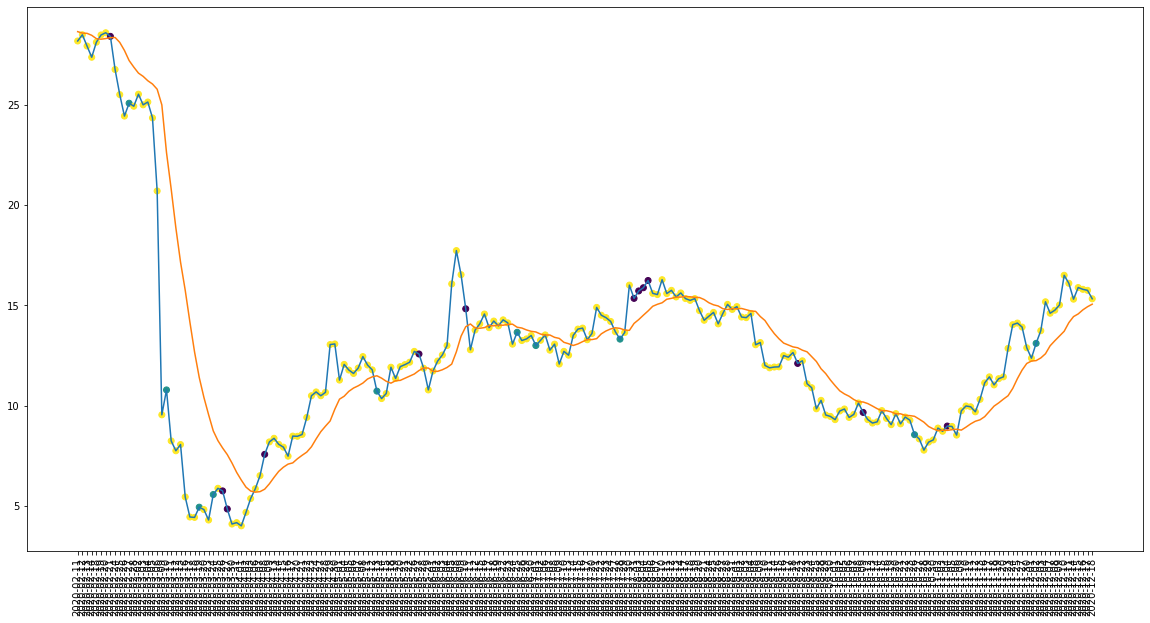

In [125]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

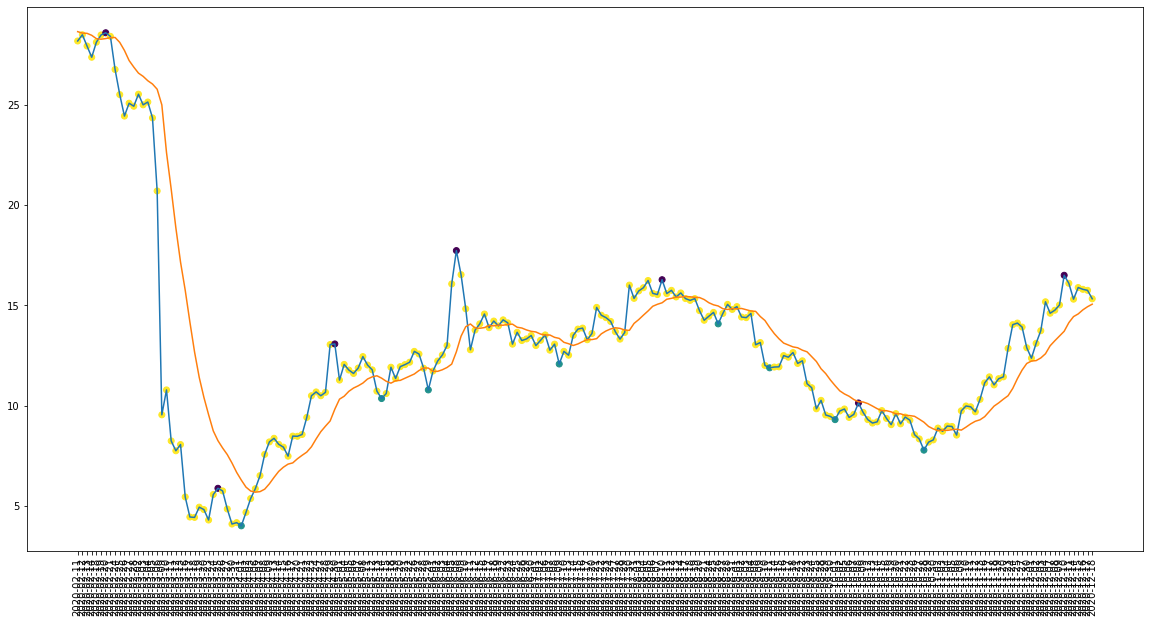

In [126]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [127]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 10
actual holds but predicted sell: 13
actual predicted holds: 181
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 88.72549019607843%
actual buys: 8
actual sells: 7
actual holds: 204
[26.75, 27.36000061035156, 27.920000076293945, 28.11000061035156, 28.170000076293945, 28.399999618530273, 28.46999931335449, 28.479999542236328, 28.57999992370605]
[24.43000030517578, 24.920000076293945, 24.989999771118164, 25.06999969482422, 25.5, 25.520000457763672, 26.75, 28.399999618530273, 28.57999992370605]
Percentage buys correct: 50.0%
Percentage sells correct: 76.92307692307692%
Percentage holds correct: 83.58974358974359%


In [128]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $25.06999969482422
Shares owned at the moment: 397
Cash capital at the moment: $19.83994898796118


Stop Loss Activated!

Share price: $24.34000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9656.246814398766


Share price: $10.789999961853027
Shares owned at the moment: 892
Cash capital at the moment: $5.098978519439697


Stop Loss Activated!

Share price: $8.25
Shares owned at the moment: 0
Cash capital at the moment: $7343.86172851944


Share price: $4.949999809265137
Shares owned at the moment: 1479
Cash capital at the moment: $2.6791238920686737


Stop Loss Activated!

Share price: $4.309999942779541
Shares owned at the moment: 0
Cash capital at the moment: $6359.63919199574


Share price: $5.579999923706055
Shares owned at the moment: 1136
Cash capital at the moment: $3.3273589040036313


Stop Loss Activated!

Share price: $4.860000133514403
Shares owned at the moment: 0
Cash capital at the moment: $5509.104870159267


Share price: $10.729999542

In [129]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5412.292695983887
profit gained: -45.87707304016113%


In [130]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.779817,11.11111111111111%,0.0%,84.07960199004975%,47.36842105263158%,35.714285714285715%,80.43478260869566%,-16.38254588816177%,-25.439673803329487%
1,0.808219,12.5%,0.0%,86.27450980392157%,50.0%,66.66666666666667%,83.5978835978836%,-58.396856798566645%,-45.87707304016113%
2,0.784404,11.11111111111111%,0.0%,84.57711442786069%,53.333333333333336%,52.94117647058823%,80.0%,-6.290706476936411%,-25.439673803329487%
3,0.826484,0.0%,0.0%,88.72549019607843%,50.0%,76.92307692307692%,83.58974358974359%,-43.10648877324466%,-45.87707304016113%


In [131]:
experiment

'APA Variation 6 CNN Images Experiment'

In [132]:
log.to_csv('{}.csv'.format(experiment))